<a href="https://colab.research.google.com/github/adityaexe2398/ROSP-Mini-project/blob/main/Sentimental_Analysis_on_Restaurant_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's load some library needed throughout the analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True


load in the dataset and add some columns for upvote metrics:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
odf = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


<ipython-input-8-eb16511c8b2e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})


Text(0.5, 1.0, 'How helpful users find among user scores')

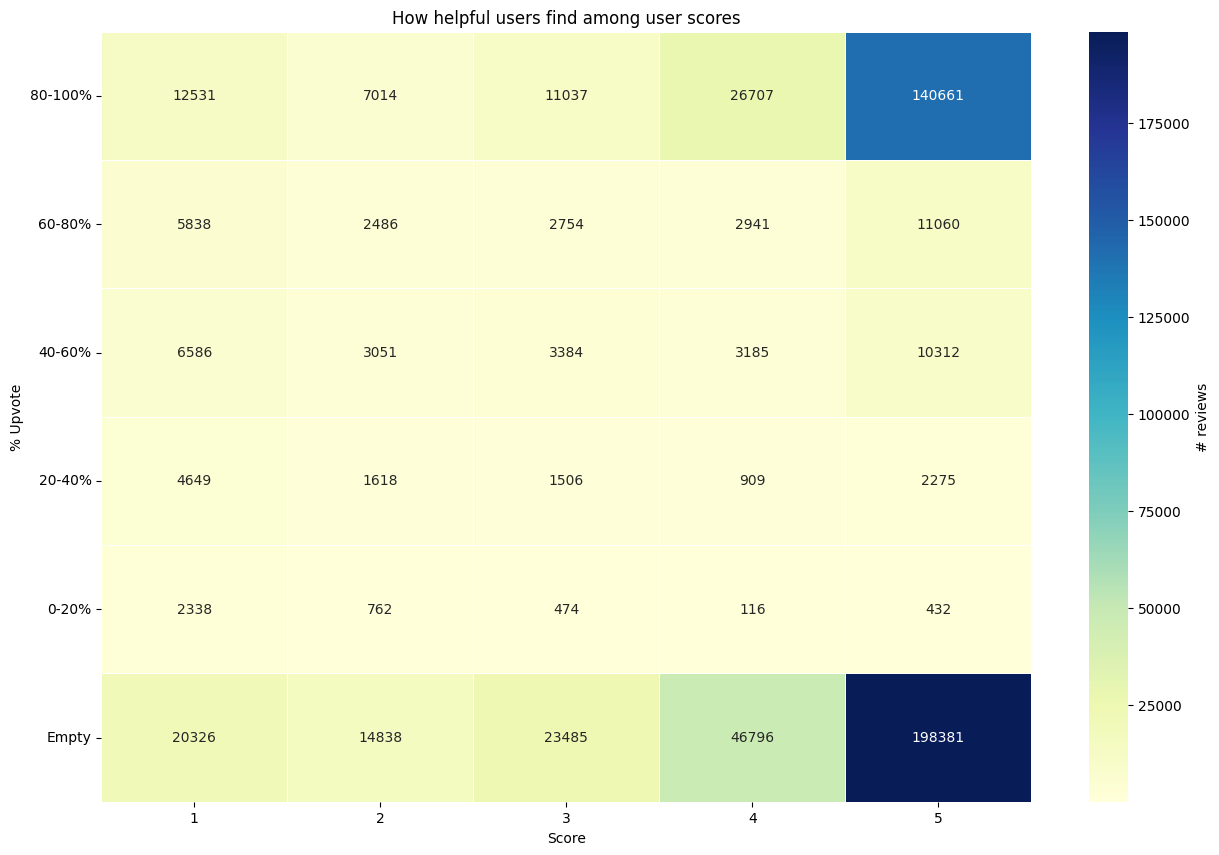

In [ ]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = "YlGnBu", linewidths =.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:


*   Reviews are skewed towards positive
*   More than half of the reviews are with zero votes
* Many people agree with score 5 reviews

Then we get rid of score 3 reviews(Neutral), and separate the remaining reviews into binary class(1 = positive, 0 = negative):



In [ ]:
df = odf[odf['Score'] !=3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

# **Score Prediction**

Logistic regression model on word count

In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):

    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))

    if coef_show == 1:
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coeff_df.tail(20).to_string(index=False))


text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9358711031995983

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.081932
   downside     3.008347
  addicting     2.864740
   drawback     2.589547
  skeptical     2.404706
     resist     2.311919
 economical     2.181748
    easiest     2.157082
   soothing     2.150020
       whim     2.148405
     hooked     2.104908
  excellent     2.054492
    welcome     2.021190
  delighted     1.983211
      meets     1.919180
        yay     1.909928
wonderfully     1.894116
    awesome     1.889735
    worries     1.889055
     delish     1.881377

-Top 20 negative-
          Word  Coefficient
         blech    -2.253169
      terrible    -2.255888
    unbearable    -2.279700
    unfinished    -2.281733
           ick    -2.370663
disappointment    -2.376734
    overpowers    -2.400302
   disapointed    -2.438603
   unappealing    -2.467081
       defeats    -2.550793
    returnable    -2.603048
      mediocre    -2.619699
        ripoff    -2.754350
   embarra

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficient are not meaningful.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [ ]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.8437324082949168


**Logistic regression model on TFIDF**

In [ ]:
tfdif = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfdif, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.9324478524807157

-Top 20 positive-
     Word  Coefficient
    great    13.899134
delicious    12.626296
  perfect    11.552890
     best    11.362999
excellent    10.864894
   highly     9.825531
    loves     9.421693
     love     9.139284
  amazing     9.122496
  awesome     9.053956
wonderful     8.706767
    yummy     8.142166
  pleased     8.125439
fantastic     7.920065
   smooth     7.801220
   hooked     7.475357
     glad     7.221367
     good     6.954906
    thank     6.922117
     nice     6.711681

-Top 20 negative-
          Word  Coefficient
         sadly    -6.079420
           rip    -6.091603
         hopes    -6.202092
    unpleasant    -6.296242
          poor    -6.351796
         bland    -6.473530
          yuck    -6.879776
        return    -6.946868
         threw    -7.273058
         worse    -7.286475
 unfortunately    -7.316409
    disgusting    -7.537229
     tasteless

Accuracy is roughly the same - 93.5%. However we notice that significant words make much more sense now, with higher coefficient magnitude as well!

**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454
Model Accuracy: 0.9440032254628996

-Top 20 positive-
     Word  Coefficient
    great    20.494694
delicious    17.893098
     best    17.359653
  perfect    15.468515
excellent    14.130888
     love    13.872813
    loves    13.674790
wonderful    12.157343
     good    12.146601
  amazing    10.809740
     nice    10.716120
 favorite    10.546447
  awesome    10.504931
  pleased    10.032497
   smooth     9.577041
    yummy     9.514872
     easy     9.224219
    happy     8.943219
   highly     8.881697
     glad     8.737520

-Top 20 negative-
          Word  Coefficient
       thought    -8.182725
         sorry    -8.245294
          poor    -8.340052
        hoping    -8.736594
     tasteless    -8.951255
         worse    -9.162558
    disgusting    -9.540418
          weak    -9.677262
         bland    -9.766144
         threw    -9.789610
         stale    -9.861784
        return   -10.565374
disappointmen

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see words like "tasty, yummy" in the result.

# **Upvote prediction**

**Data preview**

This study is to see whether is pattern found for unpopular(downvote) comments by users(might be used to boost sales). We will be focusing on score 5 reviews, and get rid of comments with neutral votes:*italicized text*

In [ ]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
% Upvote
1.0    151721
0.0      2707
Name: count, dtype: int64


The traget class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:

In [ ]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


**Logic regression model on word count**

In [ ]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15845
# train records: 4060
# test records: 1354
Model Accuracy: 0.7149187592319055

-Top 20 positive-
         Word  Coefficient
       prices     1.338990
         chai     1.253492
   assortment     1.181159
    favorites     1.156123
       orange     1.135715
       bitter     1.113367
      suggest     1.106371
  outstanding     1.100302
        value     1.088277
       overly     1.077395
    allergies     1.072853
          com     1.062583
      noticed     1.061656
      crunchy     1.047355
      mustard     1.040087
        soooo     1.028779
       single     1.022459
      dessert     1.019297
unfortunately     1.004662
     benefits     0.999879

-Top 20 negative-
     Word  Coefficient
    batch    -0.973393
   skinny    -1.002131
    money    -1.006768
   easier    -1.016361
  weather    -1.019824
     miss    -1.025011
     sick    -1.026476
    kashi    -1.048124
   caviar    -1.058149
satisfies    -1.079266
     zico    -1.100435
 brooklyn    -1.171496


The words look no sense at all, and the coefficient are very small.

**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 141640
# train records: 4060
# test records: 1354
Model Accuracy: 0.7437223042836041

-Top 20 positive-
   Word  Coefficient
   food     1.764670
    mix     1.544205
 flavor     1.523363
   salt     1.482913
   make     1.301472
chicken     1.286614
    bag     1.265518
  small     1.243245
   just     1.204780
    box     1.144770
  chips     1.070522
 gluten     1.022344
  foods     1.006903
   rice     0.975110
  white     0.957422
  value     0.923050
started     0.910896
 bitter     0.904889
flavors     0.891592
    tea     0.884530

-Top 20 negative-
        Word  Coefficient
         pod    -0.844243
        wish    -0.869475
       wrong    -0.879583
       order    -0.918703
great coffee    -0.927781
      people    -0.934853
      thanks    -0.995434
     pleased    -1.021566
  cappuccino    -1.024586
      coffee    -1.038763
       money    -1.077416
      lipton    -1.104888
      marley    -1.112737
        know    -1.198308
        zico    -1.228037
     pro

Similar to count metric, the accuracy isn't high and words not meaningful.

**Study on non-context features**

Let's look at some examples of upvote and downvote comments:

In [ ]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score comments examples: ')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])


Downvote score comments examples: 
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object


Time to extract some possible features:

In [ ]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c =='!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  85.893240
capital_count     19.252678  13.128556
question_mark      0.180273   0.063170
exclamation_mark   0.906169   0.927965
punctuation       22.482822  18.704839


Now we train the model to predict:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5923190546528804
SVM accuracy: 0.5782865583456426


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

# **In-depth study on user behaviour**

This analysis will be carried out to focus on one specific user, on what he/she likes in terms of fine food, based on the reviews he/she had given in the past. This can be expanded to all users later on.

First let's look at how many reviews each user gave in the past:

In [ ]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending=False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

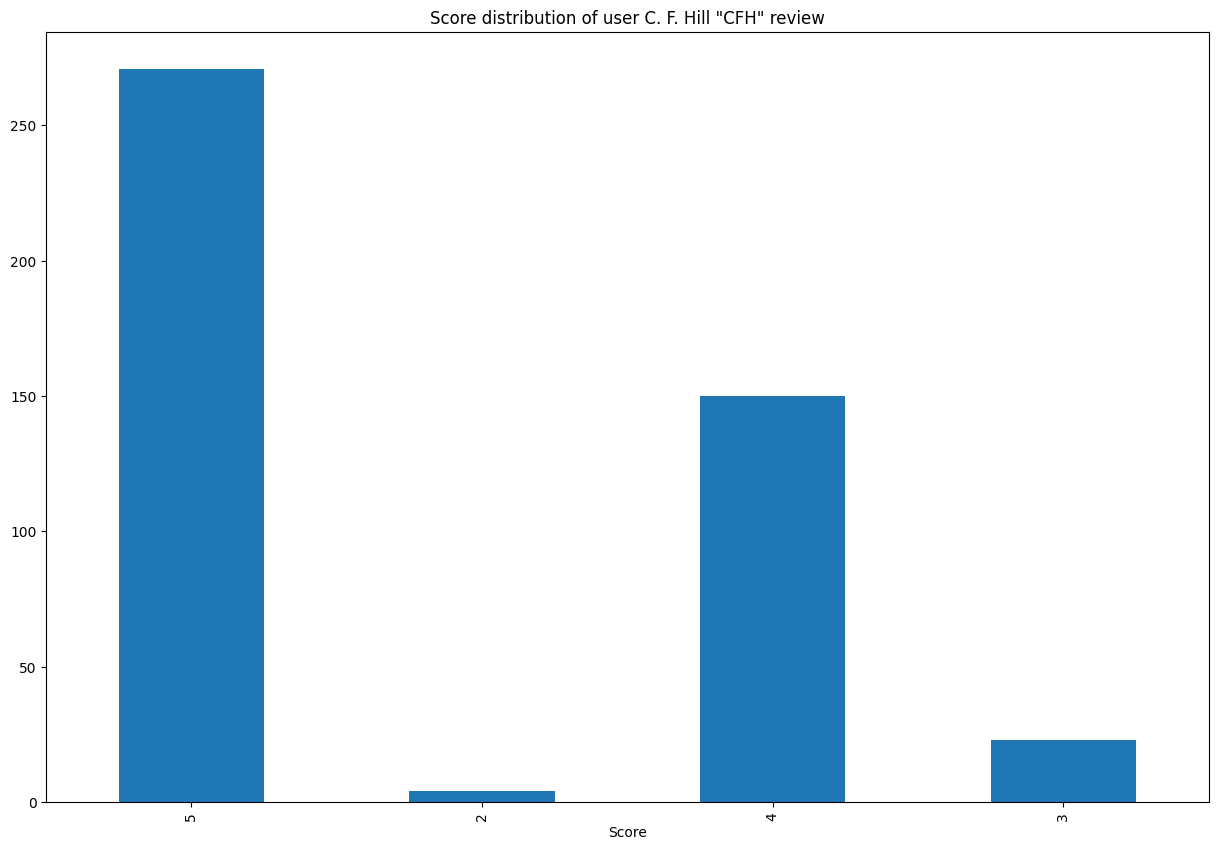

In [ ]:
def plot_user(UserId):
  df_1user = odf[odf['UserId'] == UserId]['Score']
  df_1user_plot = df_1user.value_counts(sort=False)
  ax = df_1user_plot.plot(kind = 'bar', figsize = (15, 10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's look into that:

In [ ]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Benett seems a good target:

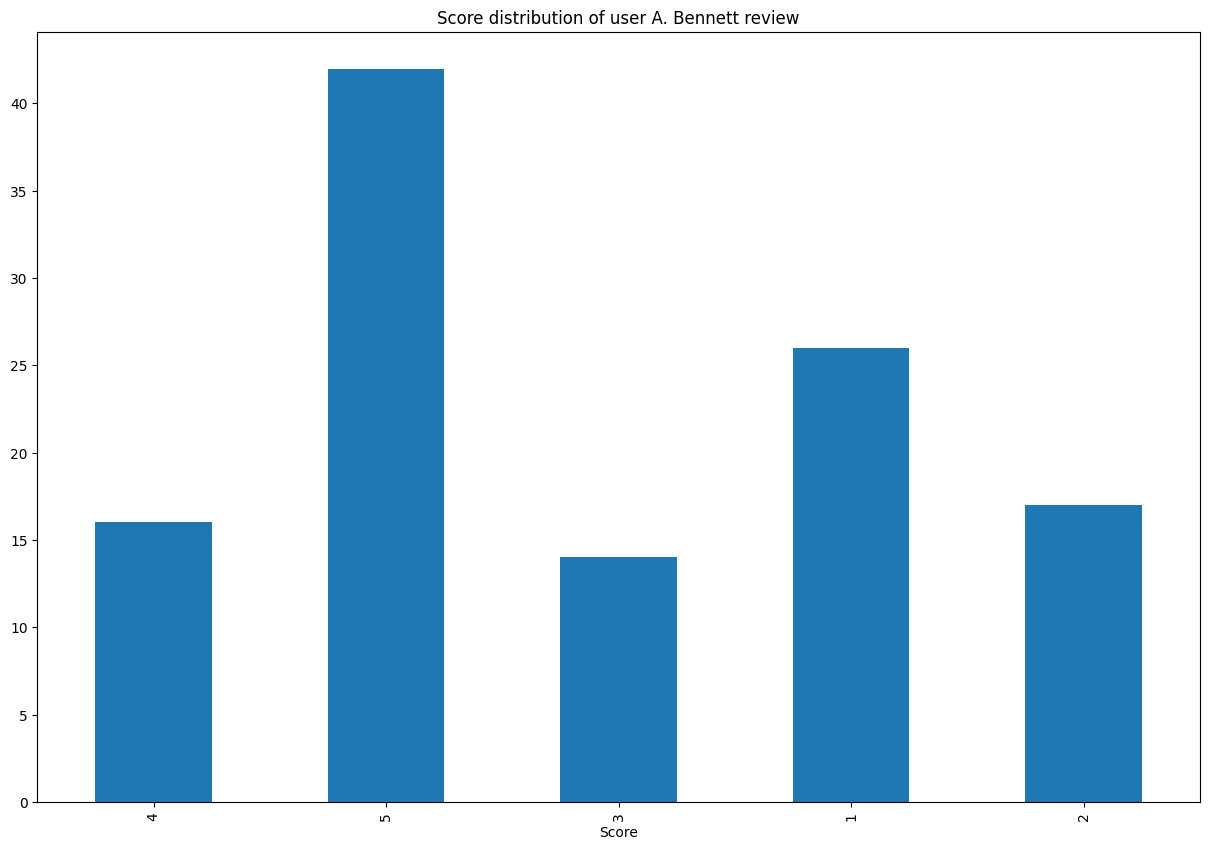

In [ ]:
plot_user('A2M9D9BDHONV3Y')

In [ ]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


He seems like a better analysis target! Now let's look deep into his reviews:

In [ ]:
def get_token_ngram(score, benchmark, userid='all'):
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w, 'v') for w in total_text]
    bigrams = ngrams(total_text, 2)
    trigrams = ngrams(total_text, 3)

    # Combine 2-gram and 3-gram
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)

    # Return phrases that occur more than benchmark of user's reviews
    return sorted([(w, fdist[w], str(round(fdist[w] / count * 100, 2)) + '%') for w in set(text) if fdist[w] >= count * benchmark], key=lambda x: -x[1])

# Score 1-5 reviews for the user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1, 6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('Score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        # Use pd.concat instead of append
        test = pd.concat([test, pd.DataFrame([i], columns=index)], ignore_index=True)
    test = test.sort_values('Count', ascending=False)
    print(test)

Score 1 reviews most popular 2-gram / 3-gram:
                    Phrase  Count Occur %
0             (never, buy)     11  42.31%
1           (buy, product)      9  34.62%
2  (monosodium, glutamate)      8  30.77%
3    (never, buy, product)      8  30.77%
4          (picture, look)      7  26.92%
5            (decide, try)      7  26.92%
6         (dry, tasteless)      7  26.92%
Score 2 reviews most popular 2-gram / 3-gram:
                  Phrase  Count Occur %
0          (ruin, whole)      8  47.06%
1   (sauce, ruin, whole)      8  47.06%
2          (sauce, ruin)      8  47.06%
3            (give, try)      7  41.18%
4        (product, ever)      6  35.29%
5             (n't, buy)      6  35.29%
6           (get, wrong)      5  29.41%
7      (give, try, like)      5  29.41%
8      (...., give, try)      5  29.41%
9      (n't, get, wrong)      5  29.41%
10            (n't, get)      5  29.41%
11     (buy, particular)      5  29.41%
12           (try, like)      5  29.41%
13          

Seems like A. bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). But Sample size is very small.

Let's look at full picture now instead of just one usr:

In [ ]:
index = ['Phrase', 'Count', 'Occur %']

for j in range(1, 6):
    test = pd.DataFrame()
    # Adjusted benchmark since we have multiple users with diverse phrases
    d = get_token_ngram(j, 0.03)
    print('Score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        # Replace append with pd.concat
        test = pd.concat([test, pd.DataFrame([i], columns=index)], ignore_index=True)
    test = test.sort_values('Count', ascending=False)
    print(test)

Score 1 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   5547  10.61%
1  (waste, money)   2330   4.46%
2    (could, n't)   2175   4.16%
3     (n't, even)   2111   4.04%
4     (n't, know)   1809   3.46%
5    (would, n't)   1794   3.43%
6      (n't, buy)   1645   3.15%
Score 2 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   3161  10.62%
1     (n't, like)   1362   4.58%
2    (would, n't)   1304   4.38%
3  (think, would)   1086   3.65%
4      (n't, buy)   1064   3.57%
5     (n't, know)   1010   3.39%
6    (n't, taste)    996   3.35%
7    (could, n't)    945   3.17%
8   (taste, good)    912   3.06%
Score 3 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   3240    7.6%
1    (would, n't)   1632   3.83%
2     (n't, like)   1612   3.78%
3   (taste, good)   1557   3.65%
4   (href=, http)   1463   3.43%
5     (n't, know)   1406    3.3%
6  (think, would)   1301   3.05%
Scor

In [ ]:
def get_token_adj(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']

    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

Let's look at user A. Benett again

In [ ]:
# Define column names
index = ['Phrase', 'Count', 'Occur %']

# Score 1-5 reviews for this user
for j in range(1, 6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('Score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        # Replace append with pd.concat
        test = pd.concat([test, pd.DataFrame([i], columns=index)], ignore_index=True)
    test = test.sort_values('Count', ascending=False)
    print(test)

# Score 1-5 reviews for this user (repeated)
for j in range(1, 6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('Score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        # Replace append with pd.concat
        test = pd.concat([test, pd.DataFrame([i], columns=index)], ignore_index=True)
    test = test.sort_values('Count', ascending=False)
    print(test)


Score 1 reviews most popular adjectives word:
      Phrase  Count Occur %
0        dry     13   50.0%
1     cheese     12  46.15%
2        bad     10  38.46%
3     little     10  38.46%
4       hard      8  30.77%
5  delicious      8  30.77%
6      tasty      8  30.77%
7  expensive      8  30.77%
8      bread      7  26.92%
9       poor      7  26.92%
Score 2 reviews most popular adjectives word:
       Phrase  Count Occur %
0       whole     10  58.82%
1      cheese      8  47.06%
2   delicious      6  35.29%
3       awful      6  35.29%
4       wrong      6  35.29%
5  particular      5  29.41%
6        good      5  29.41%
Score 3 reviews most popular adjectives word:
         Phrase  Count Occur %
0         whole      9  64.29%
1          high      5  35.71%
2         great      4  28.57%
3         first      4  28.57%
4          good      4  28.57%
5  disappointed      4  28.57%
Score 4 reviews most popular adjectives word:
      Phrase  Count Occur %
0      great      9  56.25%
1  

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
Let's also look at big picture:

In [ ]:
# Define column names
index = ['Phrase', 'Count', 'Occur %']

# Score 1-5 reviews with all users
for j in range(1, 6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('Score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        # Replace append with pd.concat
        test = pd.concat([test, pd.DataFrame([i], columns=index)], ignore_index=True)
    test = test.sort_values('Count', ascending=False)
    print(test)

Score 1 reviews most popular adjectives word:
          Phrase  Count Occur %
0           good  16216  31.02%
1            bad  10804  20.67%
2          great   4984   9.54%
3           much   4840   9.26%
4         little   4787   9.16%
5            old   4781   9.15%
6          first   4201   8.04%
7            new   3963   7.58%
8      different   3789   7.25%
9           many   3717   7.11%
10         small   3540   6.77%
11          real   3297   6.31%
12  disappointed   2999   5.74%
13          sure   2889   5.53%
14          free   2835   5.42%
15          diet   2832   5.42%
16          high   2769    5.3%
17          last   2659   5.09%
Score 2 reviews most popular adjectives word:
          Phrase  Count Occur %
0           good  13542  45.49%
1           much   4252  14.28%
2            bad   4198   14.1%
3          great   3918  13.16%
4         little   3691   12.4%
5          small   2848   9.57%
6          first   2318   7.79%
7         strong   2293    7.7%
8      diffe

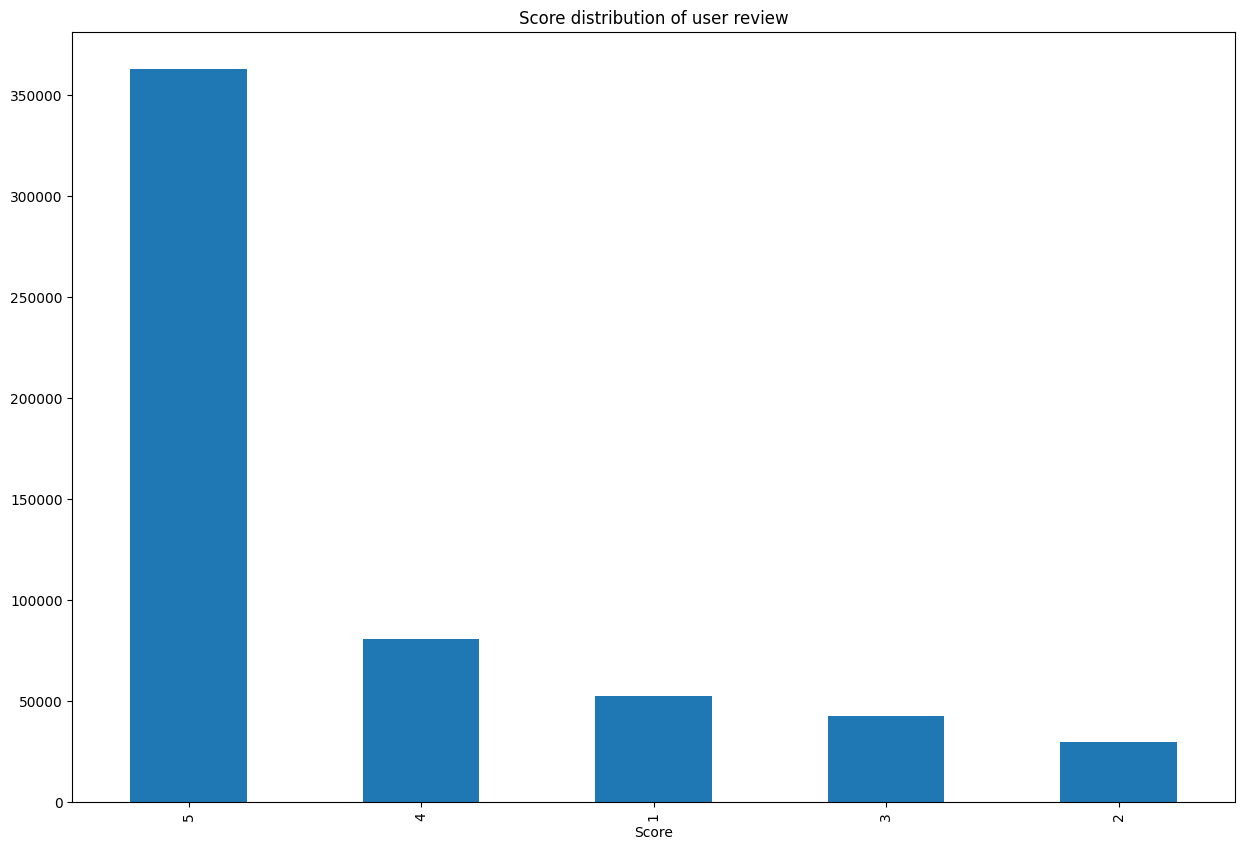

In [ ]:
def plot_users():
  df_users = odf['Score']
  df_users_plot = df_users.value_counts(sort=True)
  ax = df_users_plot.plot(kind = 'bar', figsize = (15, 10), title = 'Score distribution of user review')

plot_users()